<a href="https://colab.research.google.com/github/moshe-hadad/knesset-network/blob/main/collaboration_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
    <img src="https://en.idi.org.il/media/9162/knesset.jpg" alt="Knesset" />
    <h1>Knesset Network Project - Finding the rebel</h1>
</div>


## Basic functions to download  Knesset data and merge it to one data set.

### The table structure is as follows

| BillInitiatorID | BillID  | PersonID | FactionID | Name                                              |
|------------------|---------|----------|-----------|---------------------------------------------------|
| 0               | 171727  | 2086198  | 30701     | הליכוד בהנהגת בנימין נתניהו לראשות הממשלה          |
| 1               | 171950  | 2086395  | 30067     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 2               | 174658  | 2086395  | 30719     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 3               | 174659  | 2086395  | 30066     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 4               | 183498  | 2156051  | 30672     | יהדות התורה והשבת - אגודת ישראל דגל התורה          |


In [13]:
import pandas as pd
from tqdm import tqdm

DATA_BASE_URL ='https://raw.githubusercontent.com/moshe-hadad/knesset-network/main/data'

FACTION_URL =f'{DATA_BASE_URL}/factions.csv'
FACTION_PEOPLE_URL = f'{DATA_BASE_URL}/faction_people.csv'
PERSONS_URL = f'{DATA_BASE_URL}//KNS_Person_data.csv'
BILLS_INITIATORS_URL = f'{DATA_BASE_URL}//KNS_BillInitiator.csv'
BILLS_URL = f'{DATA_BASE_URL}/KNS_Bill.csv'
CHUNK_SIZE =10000


KNESSET_NUM = 24

# Define a function to remoatly load the data sets with a progress bar
def remote_loader(url: str, chunk_size: int = CHUNK_SIZE):
    # Initialize tqdm progress bar (unknown total)
    progress_bar = tqdm(unit="lines")
    # Read CSV in chunks with an iterator
    data_frames = pd.read_csv(url, chunksize=chunk_size)

    # Process each chunk while updating progress bar
    final_df = pd.DataFrame()  # Empty DataFrame to store results
    for chunk in data_frames:
        final_df = pd.concat([final_df, chunk], ignore_index=True)
        progress_bar.update(len(chunk))

    # Close the progress bar
    progress_bar.close()

    # Display the loaded DataFrame (optional)
    return final_df

def knesset_data_set(knesset_number=KNESSET_NUM):
  # ----------- Merge Bill and their initiator ---------------------------------
  bills_initiators = remote_loader(BILLS_INITIATORS_URL)
  bills = remote_loader(BILLS_URL)

  # Filter bills for the specific Knesset term (number)
  filter_per_knesset_term_df = bills[bills['KnessetNum'] == knesset_number]
  filter_per_knesset_term_df.head()
  # Merge the data sets
  bills_and_members = pd.merge(bills_initiators, filter_per_knesset_term_df,
                               on='BillID', how='inner')

  # ----------- Merge Factions and their members--------------------------------
  members = remote_loader(FACTION_PEOPLE_URL)
  factions_df = remote_loader(FACTION_URL)

  # members.set_index('PersonID', inplace=True)
  members = members[members['KnessetNum'] == knesset_number]
  factions_df = factions_df[factions_df['KnessetNum'] == knesset_number]
  factions_df = factions_df.drop('KnessetNum', axis=1)

  factions_and_members = pd.merge(factions_df, members, on='FactionID',
                                  how='inner')

  # ---------- Megre all to one data set ---------------------------------------
  # Drop name from bills_and_members to prevent collition with Faction Name
  bills_and_members = bills_and_members.drop('Name', axis=1)
  bills_and_factions = pd.merge(bills_and_members, factions_and_members,
                                on='PersonID', how='left')

  bills_and_factions =  bills_and_factions[['BillInitiatorID', 'BillID',
                                            'PersonID', 'FactionID', 'Name']]
  return bills_and_factions



# A walthrough of the logic of merging the data set

---
We first want to merge the billd and bills_initiator.
The bills_initiator is a connecting table between members (persons) and bills.
Since there is a many to many relationship between members and bills.  
One member can be linked to multiple bills and vice versa.  

But before we merge we filter the bills tables for all the bills from the selected knesset.  
We then merge both tables base on BillID. The results is a table containing all the members connected to thier bills issues in the selected knesset.
We call this table bills_and_members.


Next, we merge the faction (parties) and the members (persons) table.  
Again we first filter for the selected knesset. And we merge the tables based on PersonID - the results is the table of all members and thier party.
This was done to get the party name per each member.
We call this table factions_and_members

The last part is merging the factions_and_members to the bills_and_members based on the personID (member). The results is a table containing the bills in a spesific knesset, it's member and his/her party.











## Basic funtions to build factions graph from the data set




In [14]:
# prompt: From the data set bills_and_factions , I want to create a graph where each node represent a faction and there is an edge between nodes if there are members who issued a bill together. The weight of the edge is the count of such colaborations

import networkx as nx

def build_faction_graph(bills_and_factions):
    # Create an empty graph
    graph = nx.Graph()

    # Iterate through the DataFrame to create nodes and edges
    for bill_id, group in tqdm(bills_and_factions.groupby('BillID')):
        factions = group['FactionID'].unique()
        for i in range(len(factions)):
            for j in range(i + 1, len(factions)):
                faction1 = factions[i]
                faction2 = factions[j]
                if graph.has_edge(faction1, faction2):
                    graph[faction1][faction2]['weight'] += 1
                else:
                    graph.add_edge(faction1, faction2, weight=1)

    return graph


In [15]:

bills_and_factions = knesset_data_set()
faction_graph = build_faction_graph(bills_and_factions)

163991lines [00:02, 65784.07lines/s]
56328lines [00:02, 26173.03lines/s]
4035lines [00:00, 7801.08lines/s]
543lines [00:00, 894.95lines/s]
100%|██████████| 4079/4079 [00:00<00:00, 11700.06it/s]


In [16]:
# Get faction names for labels
faction_names = bills_and_factions.set_index('FactionID')['Name']

# Reverse the strings in the faction_names Series
faction_names = faction_names.apply(lambda x: x[::-1])

# Convert to dictionary for labels
faction_names = faction_names.to_dict()
faction_names

{962: 'הלשממה תושארל והינתנ ןימינב תגהנהב דוכילה',
 964: ')ד"לב ,ל"עת ,ש"דח( תפתושמה המישרה',
 965: 'הרותה לגד לארשי תדוגא - תבשהו הרותה תודהי',
 971: 'ס"ש',
 961: 'תיתדה תונויצה',
 974: 'דחא דיתע',
 968: 'ונתיב לארשי',
 967: 'דיתע שי',
 972: 'השדח הווקת',
 970: 'צרמ',
 969: 'ןבל לוחכ',
 966: 'טנב ילתפנ תושארב הנימי',
 963: 'הדובעה',
 973: 'תדחואמה תיברעה המישרה'}

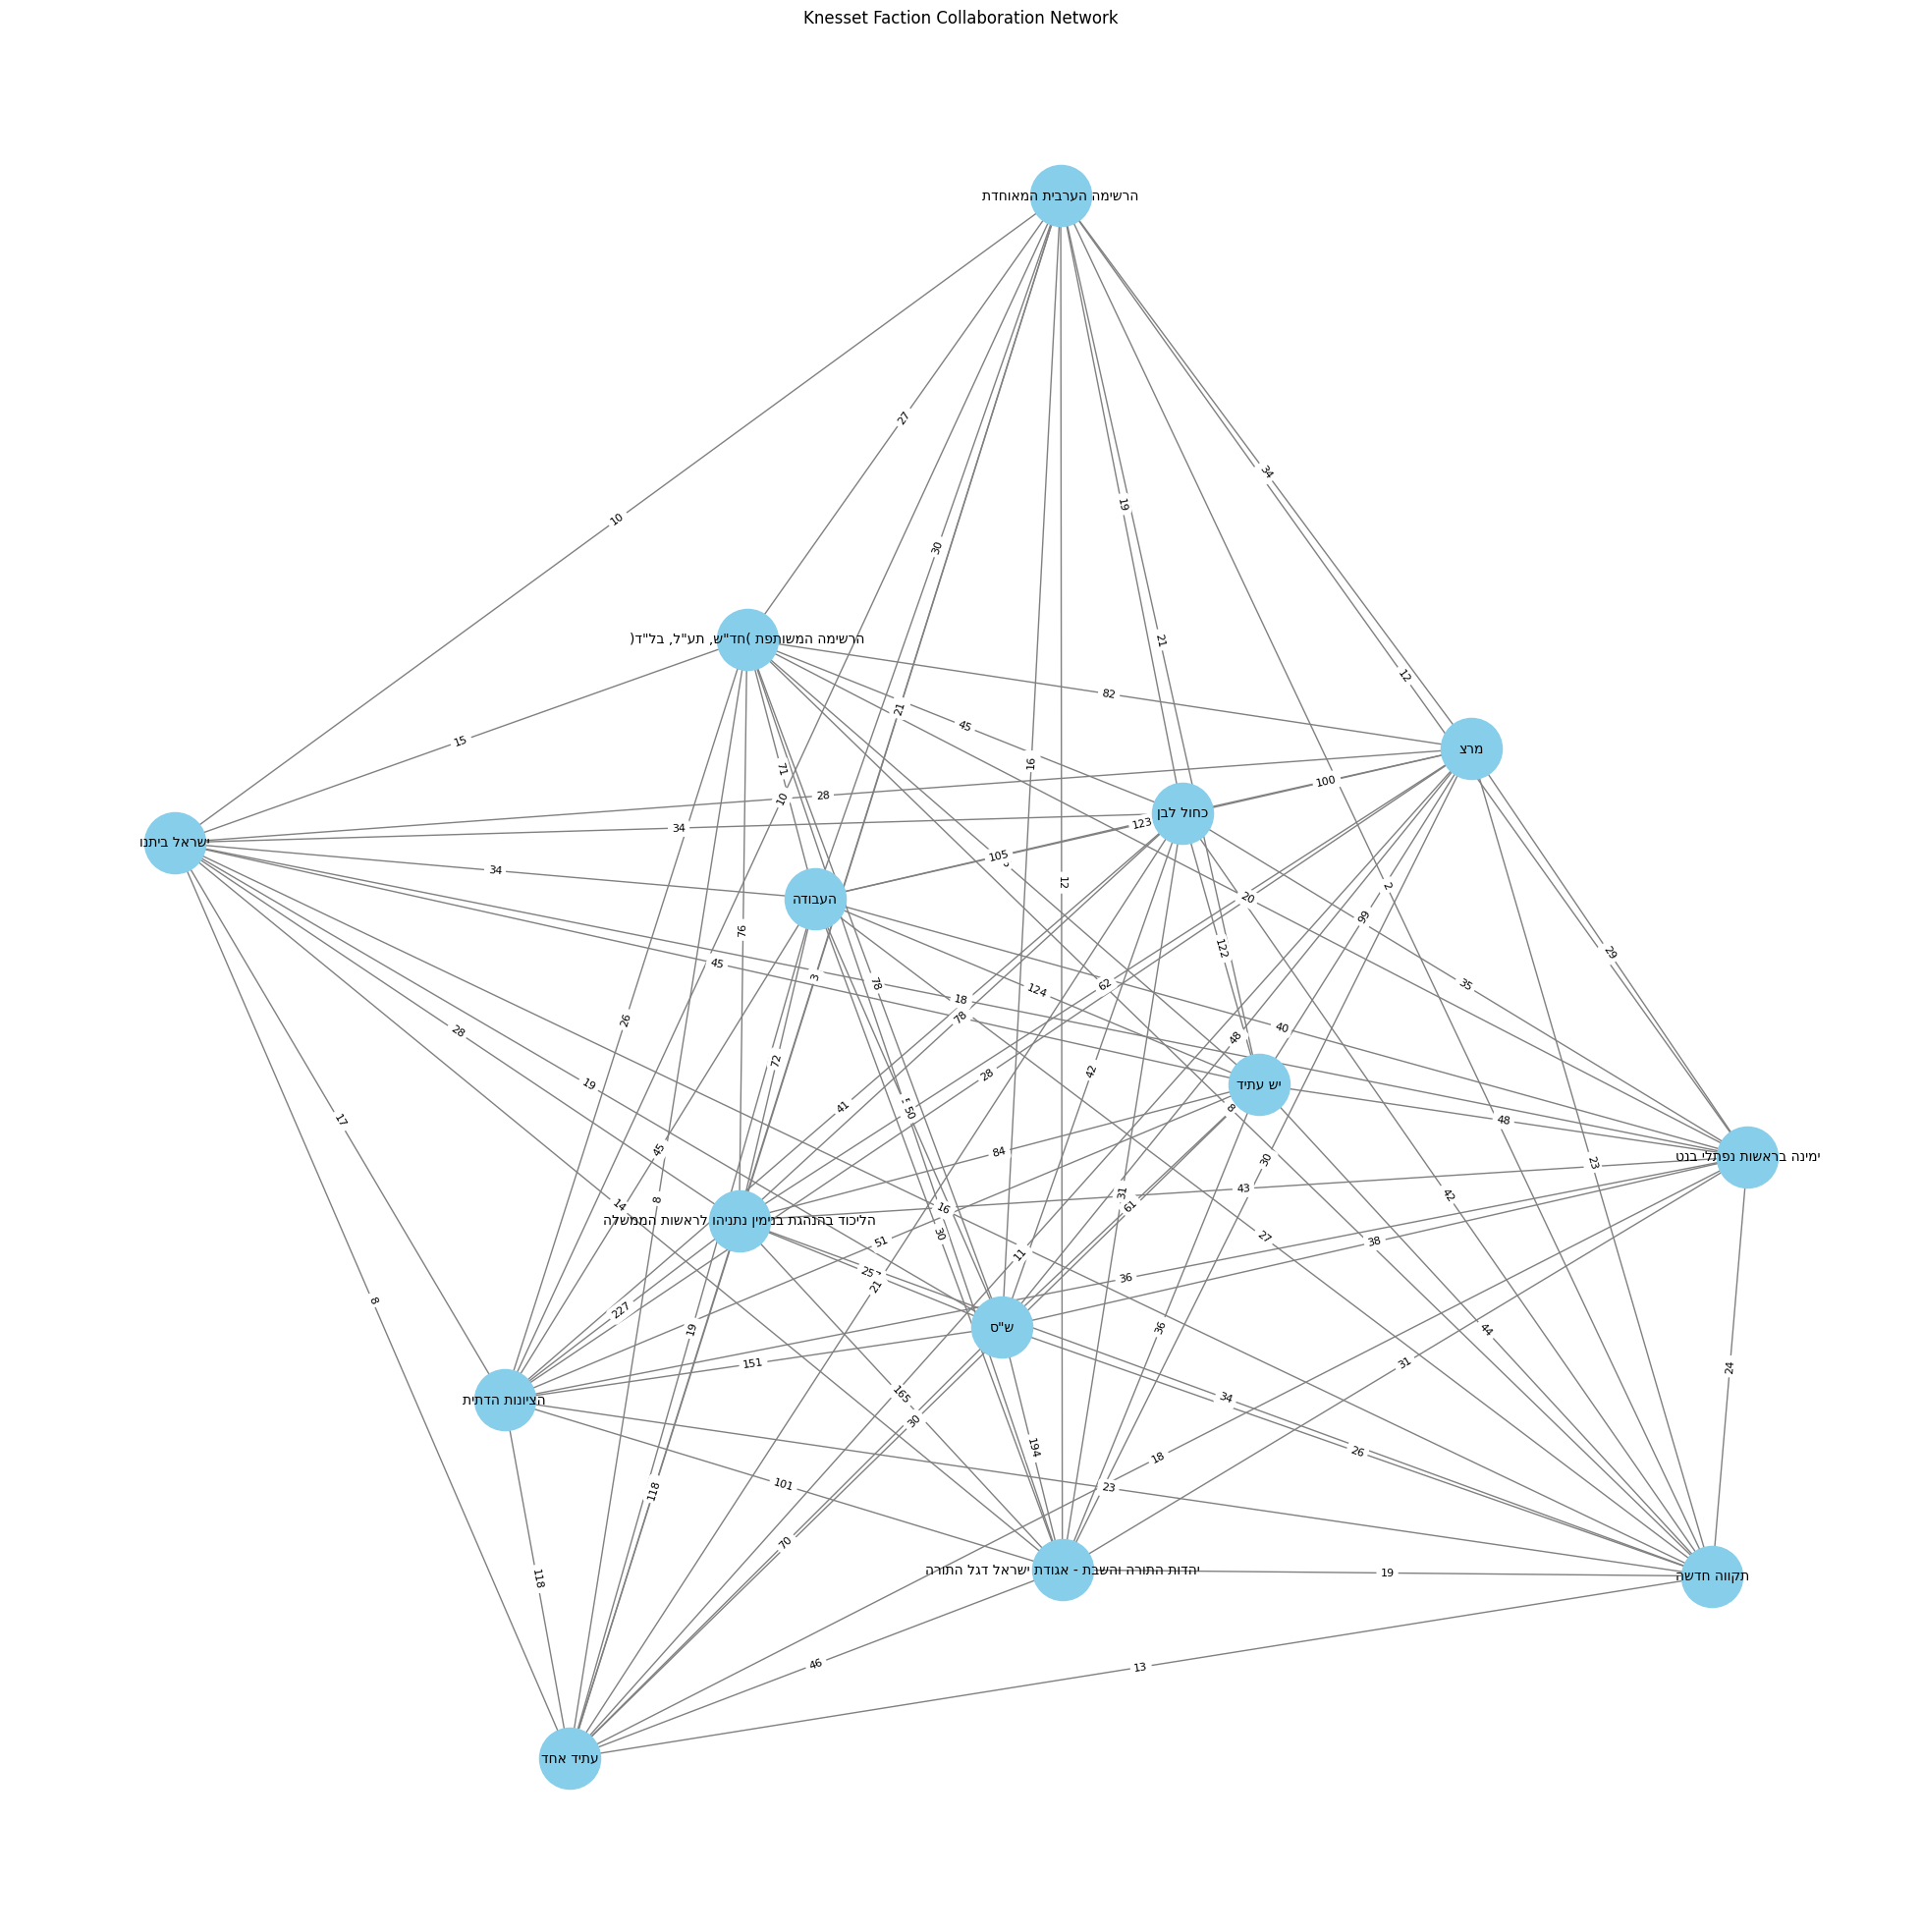

In [17]:
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(25, 25))


# Draw the graph with faction names as labels
pos = nx.spring_layout(faction_graph, k=0.5, iterations=50)  # Positioning for better visualization
nx.draw_networkx(faction_graph, pos, labels=faction_names,
                 with_labels=True, node_size=2000, font_size=10,
                 node_color="skyblue", font_color="black",  edge_color="grey")


# Get and display edge weights
edge_weights = nx.get_edge_attributes(faction_graph, 'weight')
nx.draw_networkx_edge_labels(faction_graph, pos, edge_labels=edge_weights,
                             font_size=8)

plt.title("Knesset Faction Collaboration Network")
plt.axis('off')  # Hide axis
plt.show()



# Validating Data

---

Let's try to validate the data for the הרשימה הערבית המאוחדת and תקווה חדשה
From the graph, it looks like they have only 2 bills issued together for the 24th knesset

In [18]:
factions_df = remote_loader(FACTION_URL)
factions_for_24 =factions_df[factions_df['KnessetNum'] == 24]
# 'הרשימה הערבית המאוחדת' = 973
# 'תקווה חדשה' = 972




543lines [00:00, 1216.54lines/s]


In [19]:
# Extract all bills which are issued by members of factions with IDs 972 and 972
# for the 24th Knesset
bills_initiators = remote_loader(BILLS_INITIATORS_URL)
bills = remote_loader(BILLS_URL)

# Filter bills for the specific Knesset term (number)
filter_per_knesset_term_df = bills[bills['KnessetNum'] == 24]
# Merge the data sets
bills_and_members = pd.merge(bills_initiators, filter_per_knesset_term_df,
                              on='BillID', how='inner')

# ----------- Merge Factions and their members--------------------------------
members = remote_loader(FACTION_PEOPLE_URL)
members_of_973 = members[members['FactionID'].isin([973])]
members_of_972 = members[members['FactionID'].isin([972])]

163991lines [00:01, 93900.87lines/s] 
56328lines [00:01, 49138.13lines/s]
4035lines [00:00, 6055.76lines/s]


In [20]:
list_of_973_members = list(members_of_973['PersonID'])
list_of_972_members  = list(members_of_972['PersonID'])


In [21]:

bills_of_members_of_973_for_knesset_24 = bills_and_members[bills_and_members['PersonID'].isin(list_of_973_members)]
bills_of_members_of_972_for_knesset_24 = bills_and_members[bills_and_members['PersonID'].isin(list_of_972_members)]

In [22]:
joint_bills_of_973_and_972 = pd.merge(bills_of_members_of_973_for_knesset_24, bills_of_members_of_972_for_knesset_24, on='BillID', how='inner')
joint_bills_of_973_and_972

,BillInitiatorID_x,BillID,PersonID_x,IsInitiator_x,Ordinal_x,LastUpdatedDate_x_x,KnessetNum_x,Name_x,SubTypeID_x,SubTypeDesc_x,...,PostponementReasonDesc_y,PublicationDate_y,MagazineNumber_y,PageNumber_y,IsContinuationBill_y,SummaryLaw_y,PublicationSeriesID_y,PublicationSeriesDesc_y,PublicationSeriesFirstCall_y,LastUpdatedDate_y_y
0,189895,2159427,30803,True,29,2021-07-04T14:22:58.647,24,"הצעת חוק יום בריאות הנפש, התשפ""א-2021",54,פרטית,...,"הסרה מסד""י בד. מוקדם",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-10T10:51:59.303
1,189895,2159427,30803,True,29,2021-07-04T14:22:58.647,24,"הצעת חוק יום בריאות הנפש, התשפ""א-2021",54,פרטית,...,"הסרה מסד""י בד. מוקדם",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-10T10:51:59.303
2,189895,2159427,30803,True,29,2021-07-04T14:22:58.647,24,"הצעת חוק יום בריאות הנפש, התשפ""א-2021",54,פרטית,...,"הסרה מסד""י בד. מוקדם",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-10T10:51:59.303
3,192055,2161234,30713,True,38,2021-10-27T13:49:51.9,24,הצעת חוק שידורי טלוויזיה (כתוביות ושפת סימנים)...,54,פרטית,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"הצ""ח הכנסת (מתשס""ג 10/2002) - 893 ,מיום 16:00:00",2022-11-10T10:51:59.303
4,192055,2161234,30713,True,38,2021-10-27T13:49:51.9,24,הצעת חוק שידורי טלוויזיה (כתוביות ושפת סימנים)...,54,פרטית,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"הצ""ח הכנסת (מתשס""ג 10/2002) - 893 ,מיום 16:00:00",2022-11-10T10:51:59.303


In [23]:
len(joint_bills_of_973_and_972['BillID'].unique())

2

# **Comunity Detection Over Faction Graph**

In [24]:
from community import community_louvain
# Perform community detection
partition = community_louvain.best_partition(faction_graph)

# Get the number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")


SyntaxError: invalid syntax (<ipython-input-24-fc28d998d419>, line 1)

In [ ]:
import numpy as np
# Draw node labels
# Generate a list of distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
color_map = {i: colors[i] for i in range(num_communities)}

# Create a larger figure
plt.figure(figsize=(10, 10))

# Draw the graph
pos = nx.spring_layout(faction_graph, k=0.5, iterations=50)


# Draw nodes colored by community
node_colors = [color_map[partition[node]] for node in faction_graph.nodes()]
nx.draw_networkx_nodes(faction_graph, pos, node_size=1000, node_color=node_colors)

# Generate a list of distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
color_map = {i: colors[i] for i in range(num_communities)}

nx.draw_networkx_labels(faction_graph, pos, labels=faction_names,
                        font_size=10, font_weight="bold")

# Draw edges
nx.draw_networkx_edges(faction_graph, pos, width=0.5, alpha=0.5)

# Draw edge labels (weights)
edge_weights = nx.get_edge_attributes(faction_graph, 'weight')
nx.draw_networkx_edge_labels(faction_graph, pos, edge_labels=edge_weights, font_size=8)

plt.title(f"Faction Relationship Graph - {num_communities} Communities Detected", fontsize=20)
plt.axis('off')
plt.tight_layout()

# Save the graph as a high-resolution image
plt.savefig("faction_graph_communities.png", format="png", dpi=300, bbox_inches='tight')

# Display the graph
plt.show()


# Members's Graph
We now build the lower level colaboration graph  
Each node represent a member and an edge indicated those two members colaborating together on a bill.  



In [ ]:
data_for_24th_keneset = knesset_data_set(24)
data_for_24th_keneset.info()

In [ ]:
members_into = remote_loader(PERSONS_URL)
members_into.info()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
def create_members_graph(df_bills, df_members):
  # Merge personal info into bills dataset to get full names
  df = df_bills.merge(df_members[['PersonID', 'FirstName', 'LastName']], on='PersonID', how='left')
  df['FullName'] = df['FirstName'].fillna('') + ' ' + df['LastName'].fillna('')

  # Group by BillID to find co-initiators
  bill_groups = df.groupby('BillID')['FullName'].apply(list)

  # Create graph
  G = nx.Graph()

  # Add edges for co-initiators
  for names in bill_groups:
      # Add nodes and edges between all combinations of co-initiators
      for name1, name2 in combinations(set(names), 2):
          if G.has_edge(name1, name2):
              G[name1][name2]['weight'] += 1
          else:
              G.add_edge(name1, name2, weight=1)

  # Draw graph (simple layout)
  plt.figure(figsize=(24, 24))
  pos = nx.spring_layout(G, k=1.5, iterations=100)

  nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
  nx.draw_networkx_edges(G, pos, width=1, alpha=0.3)

  # Hebrew names
  nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

  # Edge labels: number of joint bills
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='gray')

  # Draw nodes and edges
  nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
  nx.draw_networkx_edges(G, pos, alpha=0.3)
  nx.draw_networkx_labels(G, pos, font_size=8)

  plt.title("חברי כנסת שיזמו חוקים יחד", fontsize=20)
  plt.axis('off')
  plt.show()


In [ ]:
create_members_graph(data_for_24th_keneset,members_into)